In [1]:
import qiskit
from qiskit.providers import BaseBackend
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Decompose
from dc_qiskit_algorithms import MöttönenStatePreparationGate

In [2]:
from dc_qiskit_qml import QiskitOptions
from dc_qiskit_qml.encoding_maps import NormedAmplitudeEncoding
from dc_qiskit_qml.distance_based.hadamard import QmlHadamardNeighborClassifier
from dc_qiskit_qml.distance_based.hadamard.state import QmlGenericStateCircuitBuilder
from dc_qiskit_qml.distance_based.hadamard.state.sparsevector import MottonenStatePreparation

# Creating the classifier

We need 

 * circuit state builder (here we use the preparation algorithm by Möttönen et al.)
 * Execution Backend (qasm simulator qiskit-aerby IBMQ)
 * Options for transpilation and execution
 * Choose an encoding map -- the default is normed amplitude encoding (classical to quantum map)  

In [3]:
initial_state_builder = QmlGenericStateCircuitBuilder(MottonenStatePreparation())

execution_backend: BaseBackend = qiskit.Aer.get_backend('qasm_simulator')
options = QiskitOptions(shots=8192,optimization_level=3)
qml = QmlHadamardNeighborClassifier(backend=execution_backend, 
                                    classifier_circuit_factory=initial_state_builder,
                                    encoding_map=NormedAmplitudeEncoding(),
                                    options=options)

We use from the IRIS data set 

 * training data #33 & #85
 * test data #26 & #36

In [4]:
import numpy as np

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris

X, y = load_iris(True)
X = np.asarray([x[0:2] for x, y in zip(X, y) if y != 2])
y = np.asarray([y for x, y in zip(X, y) if y != 2])

X_train = X[[33, 85]]
y_train = y[[33, 85]]

X_test = X[[28, 36]]
y_test = y[[28, 36]]

Use the sci-kit learn pipeline in order to create standard-scaled l2-normalized input data classification

In [5]:
pipeline = Pipeline([
    ('scaler',  StandardScaler()), 
    ('l2norm', Normalizer(norm='l2', copy=True)),
    ('qml', qml)
])

### Plot the data

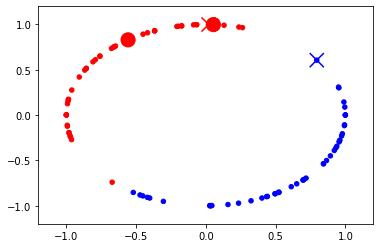

In [6]:
import matplotlib.pyplot as plt

_X = pipeline.fit_transform(X, y)
_X_train = pipeline.transform(X_train)
_X_test = pipeline.transform(X_test)


plt.scatter(
    _X[:,0], _X[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y],
    s=20)
plt.scatter(
    _X_train[:,0], _X_train[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_train],
    marker='x', s=200)
plt.scatter(
    _X_test[:,0], _X_test[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_test],
    marker='o', s=200)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.show()

### Predict / Classify

In [7]:
pipeline.fit(X_train, y_train)
pipeline.predict(X_test), y_test

([0, 0], array([0, 0]))

## Understanding the circuits

On a high level, the Möttönen state preparation is a multi-qubit gate. The following $Z R_y$ instruction is
 a disguised Hadamard gate: we introduced it to enable _ensemble_ methods.  

In [8]:
qml._last_predict_circuits[0].draw(line_length=120)

we will *decompose* the state preparation by Möttönen et al. using qiskit's decompose pass. For this we create a *new* 
pass manager for only this job!

In [9]:
qiskit.transpile(circuits=qml._last_predict_circuits[0], 
                 pass_manager=PassManager([Decompose(MöttönenStatePreparationGate)])).draw(line_length=120)

As we see, there are two "cascades" of uniform rotations (Möttönen et al.) one for $R_y$ rotations -- used for the 
amplitudes -- and one for $R_z$ rorations -- for the phases (including sign!). 

This doesn't look too bad. But each uniform rotation has $\mathcal{O}(2^n)$ gates where $n$ is the number of qubits. In
the end this will create a very long circuit.

In [10]:
qiskit.transpile(circuits=qml._last_predict_circuits[0], 
                 basis_gates=['cx', 'u1', 'u2', 'u3'], 
                 optimization_level=0).draw(fold=120)

However a little bit can be optimized by increasing the optimization level:

In [11]:
qiskit.transpile(circuits=qml._last_predict_circuits[0], 
                 basis_gates=['cx', 'u1', 'u2', 'u3'], 
                 optimization_level=3).draw(fold=120)

# Now a lot more data

We are now using as trainging data #45 to # 61 and two test samples #33 & #90. 

Reason: more training data 

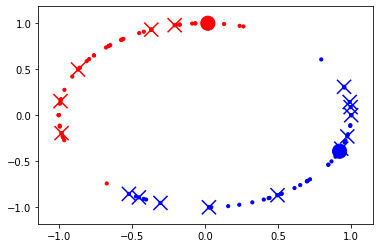

In [12]:
X_train = X[45:61]
y_train = y[45:61]

X_test = X[[33, 63]]
y_test = y[[33, 63]]

_X = pipeline.fit_transform(X, y)
_X_train = pipeline.transform(X_train)
_X_test = pipeline.transform(X_test)

plt.scatter(
    _X[:,0], _X[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y], s=10)
plt.scatter(
    _X_train[:,0], _X_train[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_train],
    marker='x', s=200)
plt.scatter(
    _X_test[:,0], _X_test[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_test],
    marker='o', s=200)
plt.show()

In [13]:
### Prediction / Classification

In [14]:
pipeline.fit(X_train, y_train)
pipeline.predict(X_test), y_test

([0, 1], array([0, 1]))

### The circuits

To get an idea of how complex this is getting. We had 4 qubits before with 2 trianing data samples! Now:

In [15]:
qml._last_predict_circuits[0].draw(line_length=120)

Now this gets decomposed to:

In [16]:
qiskit.transpile(circuits=qml._last_predict_circuits[0], 
                 pass_manager=PassManager([Decompose(MöttönenStatePreparationGate)])).draw(line_length=120)

And this is then finally the fully blown circuit

In [17]:
qiskit.transpile(circuits=qml._last_predict_circuits[0], optimization_level=0, backend=execution_backend).draw(fold=120)